In [222]:
from typing import List, Tuple
import getpass
import numpy as np
import math
from IPython.display import clear_output
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Estimator
from qiskit.circuit import Parameter, ControlledGate
from qiskit.circuit.library import UGate, CUGate, RXGate, CRXGate, RZGate, CRZGate, TwoLocal
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Statevector
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.visualization import plot_bloch_multivector
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [ ]:
channel = "ibm_quantum"
try:
    service = QiskitRuntimeService(channel=channel)
except Exception:
    QiskitRuntimeService.save_account(channel=channel, token=getpass.getpass('Enter IBM Quantum token'), overwrite=True)
    service = QiskitRuntimeService(channel=channel)

In [ ]:
service.backends()

In [ ]:
backend = "ibmq_qasm_simulator"

In [130]:
n = 4
q = 3
img_shape = (n, n, 1)

In [121]:
def b_num(num: int) -> str:
    return f"{num:b}"

def is_power_of_two(num) -> bool:
    b = b_num(num)
    return b.startswith("1") and (b[1:] == "0" * (len(b) - 1))

def n_qubits() -> int:
    pixels = n ** 2
    pixels_per_group = 2 ** q
    div_groups = pixels // pixels_per_group
    mod_groups = pixels % pixels_per_group
    return (q * (div_groups + (1 if mod_groups > 0 else 0)))

def scale_parameter(value: int, upper_limit: int=255) -> float:
    assert 0 <= value <= upper_limit
    return np.pi * (value / upper_limit)

In [122]:
n_qubits()

6

In [506]:
def create_classifier_circuit(img_shape: tuple, qubits_per_group: int) -> Tuple[QuantumCircuit, QuantumCircuit]:
    assert qubits_per_group in (2, 3)
    assert len(img_shape) == 3
    shape = (img_shape[0] * img_shape[1], )
    # scaled = list(map(scale_parameter, img.reshape(shape)))
    pixels_per_group = 2 ** qubits_per_group
    div_groups = shape[0] // pixels_per_group
    mod_groups = shape[0] % pixels_per_group
    n_groups = div_groups + (1 if mod_groups > 0 else 0)
    assert n_groups * qubits_per_group < 127
    image_qc = QuantumCircuit(n_groups * qubits_per_group)
    ansatz_qc = QuantumCircuit(n_groups * qubits_per_group)
    for g in range(n_groups):
        qubits = list(range(g * qubits_per_group, g * qubits_per_group + qubits_per_group))
        image_qc.h(qubits[:-1])
        for state in range(pixels_per_group // 2):
            if (g * pixels_per_group) + (2 * state) >= shape[0] - 1:
                break
            theta = Parameter(f"theta{g*pixels_per_group + state}")
            phi = Parameter(f"phi{g*pixels_per_group + state}")
            u = UGate(theta=theta, phi=phi, lam=0).control(qubits_per_group - 1, ctrl_state=state)
            image_qc.append(u, qubits)
        ans_theta = Parameter(f"ans_theta{g}")
        ans_phi = Parameter(f"ans_phi{g}")
        ansatz_qc.append(
            TwoLocal(
                num_qubits=len(qubits),
                rotation_blocks=[RZGate(ans_theta), RXGate(ans_phi)],
                entanglement_blocks="cx",
                entanglement="linear",
                reps=1,
                insert_barriers=True,
                skip_final_rotation_layer=False,
                parameter_prefix=f"T{g}"
            ).decompose(),
            qubits
        )
    qc = QuantumCircuit(
        n_groups * qubits_per_group
    ).compose(
        image_qc, range(n_groups * qubits_per_group)
    )
    qc.barrier()
    for g in range(n_groups - 1):
        for i in range(qubits_per_group):
            qc.cx(i * g + i, i * g + i + qubits_per_group)
    qc.barrier()
    qc = qc.compose(
        ansatz_qc, range(n_groups * qubits_per_group)
    )
    return qc, image_qc.parameters, ansatz_qc.parameters

In [507]:
def create_random_image(rng: tuple=(0, 255)) -> np.ndarray:
    assert len(rng) == 2
    assert 0 <= rng[0] <= 255
    assert 0 <= rng[1] <= 255
    assert rng[0] < rng[1]
    return np.rint(np.random.random(img_shape) * (rng[1] - rng[0]) + rng[0]).astype(np.uint8)

In [496]:
def generate_dataset(num: int):
    images = []
    labels = []
    dark = (0, 155)
    light = (100, 255)
    for i in range(num):
        lbl = np.random.randint(0, 2)
        if 0 == lbl:
            images.append(create_random_image(dark))
            labels.append(-1)
        else:
            images.append(create_random_image(light))
            labels.append(1)
    return images, labels

In [497]:
def reshape_and_rescale(img):
    return list(map(scale_parameter, img.reshape((img.shape[0] * img.shape[1],))))

Label: light
Dark: 48; Light: 52


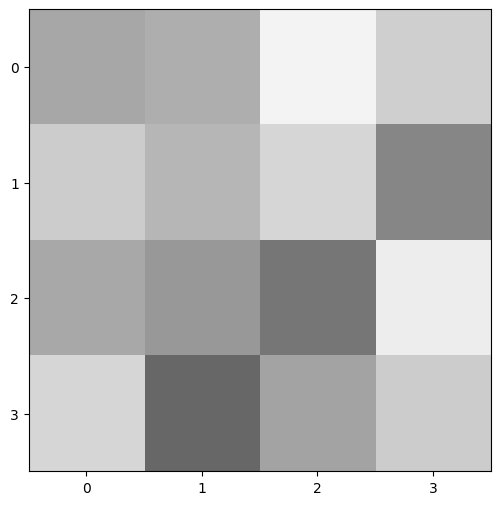

In [499]:
images, labels = generate_dataset(100)
train_images, test_images, train_labels, test_labels = train_test_split(
    list(map(reshape_and_rescale, images)), labels, test_size=0.2
)
image = images[15]
print(f"Label: {['dark', 'light'][(labels[15] + 1) // 2]}")
print(f"Dark: {labels.count(-1)}; Light: {labels.count(1)}")
plt.imshow(image, cmap="gray", vmin=0, vmax=255)
plt.xticks(np.arange(n), np.arange(n))
plt.yticks(np.arange(n), np.arange(n))
plt.show()

In [508]:
classifier_qc, input_params, weight_params = create_classifier_circuit(img_shape, q)
print(classifier_qc.depth())

7


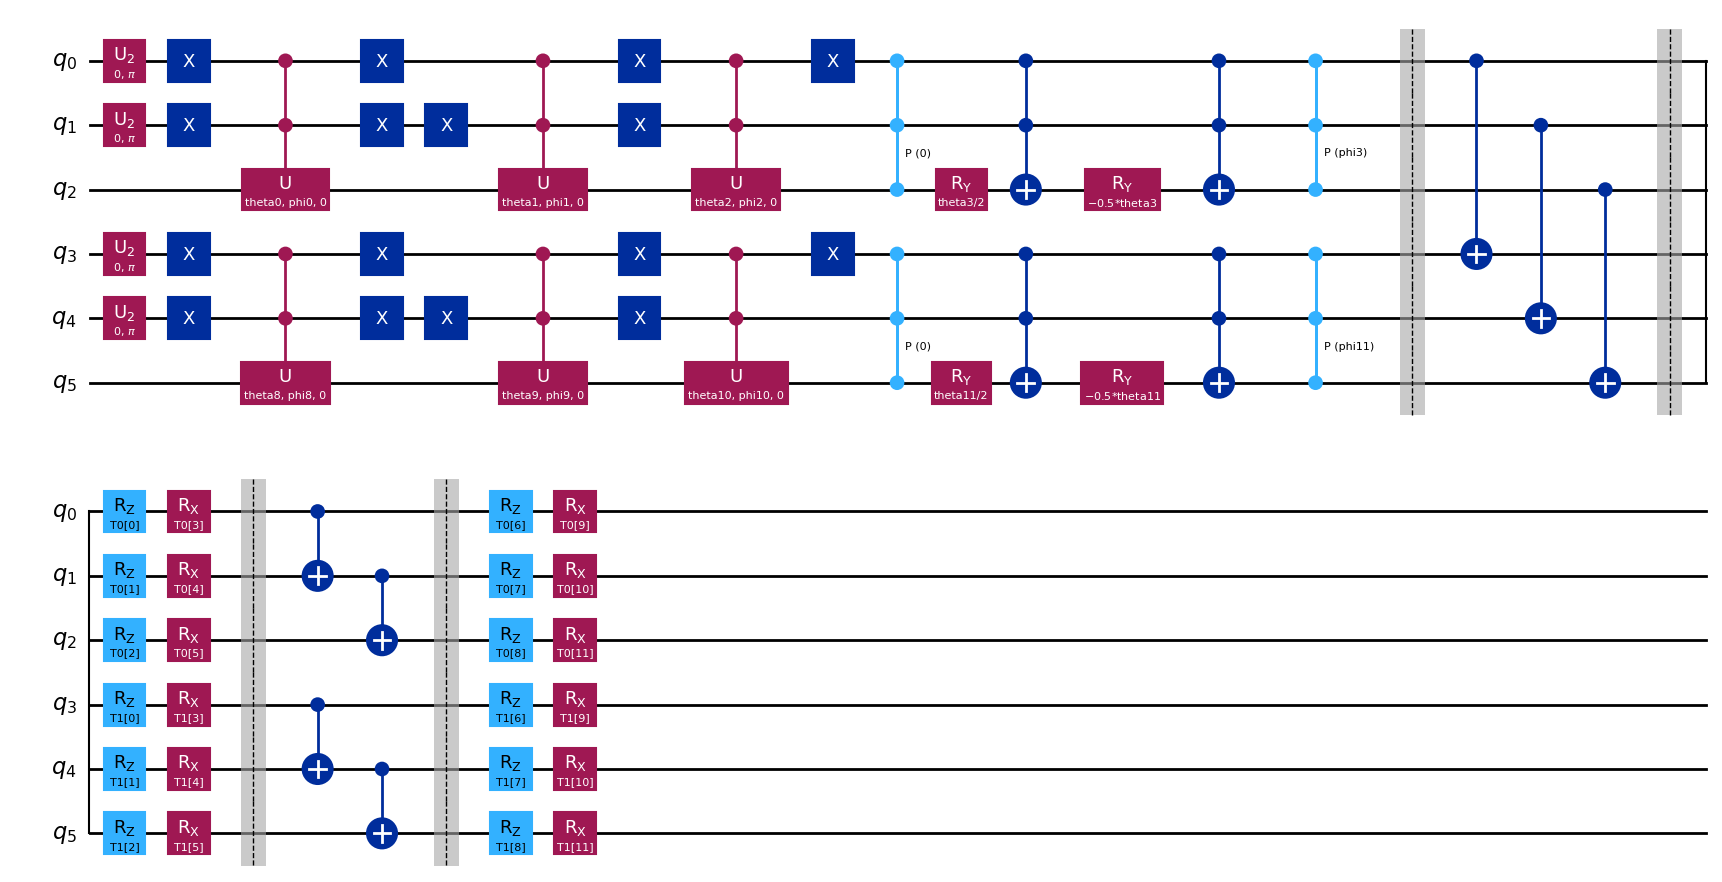

In [509]:
classifier_qc.decompose().draw("mpl", style="iqp")

In [510]:
print(len(input_params))
print(len(weight_params))

16
24


In [511]:
options = Options()
options.simulator.seed_simulator = 42
options.execution.shots = 1000
options.optimization_level = 0 # no optimization
options.resilience_level = 0 # no error mitigation
# observable = SparsePauliOp("Z" * n_qubits())
observable = SparsePauliOp.from_list([("ZIIZII", 1)])

In [512]:
qnn = EstimatorQNN(
    circuit=classifier_qc.decompose(),
    observables=observable,
    input_params=input_params,
    weight_params=weight_params,
)

In [513]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [514]:
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=100),  # Set max iterations here
    callback=callback_graph,
    initial_point=np.zeros(len(weight_params)),
)

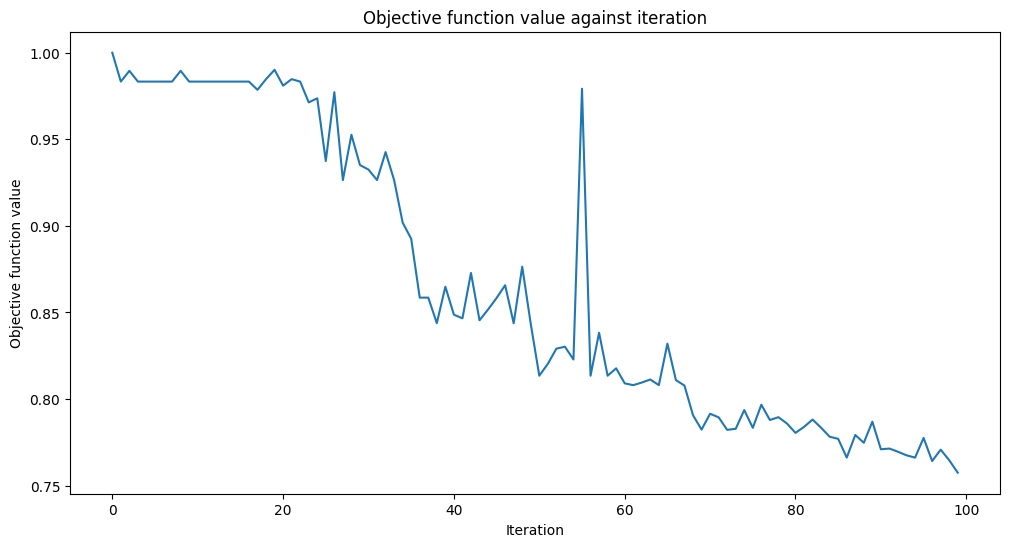

Accuracy from the train data : 82.5%


In [515]:
x = np.asarray(train_images)
y = np.asarray(train_labels)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

In [517]:
y_predict = classifier.predict(test_images)
x = np.asarray(test_images)
y = np.asarray(test_labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

Accuracy from the test data : 100.0%


In [520]:
classifier.weights

array([ 1.67119859, -1.92772973,  0.50391822, -0.77205446, -0.84411139,
        0.        , -0.78160198,  0.36712319,  0.33705003, -0.55658749,
       -0.45505111,  0.06355909,  0.07701292, -1.04313661,  0.36039978,
        0.09745997,  1.81757923,  1.10565367, -0.38676437,  0.39382772,
        1.6778322 ,  1.55590794,  1.12689082,  0.1012793 ])

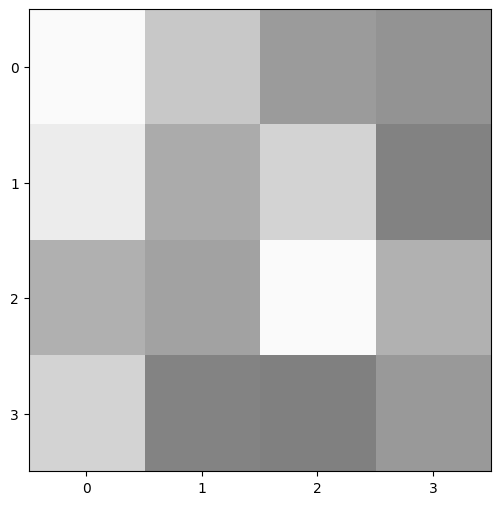

Prediction: [1.]


In [527]:
rnd_img = create_random_image((90, 255))
plt.imshow(rnd_img, cmap="gray", vmin=0, vmax=255)
plt.xticks(np.arange(n), np.arange(n))
plt.yticks(np.arange(n), np.arange(n))
plt.show()
print(f"Prediction: {classifier.predict([reshape_and_rescale(rnd_img)])[0]}")

In [ ]:
service.backends()

In [ ]:
my_qc = QuantumCircuit(3)
u = UGate(np.pi/2, np.pi/4, 0).control(2, ctrl_state=0)
my_qc.append(u, range(3))
my_qc.draw("mpl", style="iqp")

In [ ]:
t_qc = transpile(my_qc, service.backends("ibm_kyoto")[0])
print(f"Depth: {t_qc.depth()}")

In [ ]:
t_qc.draw("mpl", style="iqp")

In [ ]:
service.backends("ibm_osaka")[0].configuration().basis_gates

In [ ]:
service.instances()

In [ ]:
from qiskit_ibm_provider import IBMProvider
provider = IBMProvider(instance='ibm-q/open/main')


In [ ]:
provider.backends()[4].configuration().basis_gates